# Playing around with Natural Language Processing to improve prediction of DonorsChoose project outcomes




# NOTE - this is NOT my DSAPP application - please see the other notebook 
### (https://github.com/zwrankin/DSaPP_RA_Project/blob/master/2018_12_02_Zane_Rankin_DSAPP.ipynb)



## First step: 
I used the `nltk.sentiment.vader.SentimentIntensityAnalyzer` on the proposal title and essay. I also included word and character counts. 

## Conclusions: 
The sentiment analysis is cool, and the output seems logical. But sentiment doesn't seem to correlate very well with the outcome (correlation coefficiences <= 0.03), and the sentiment features alone don't seem to make a useful model. 
<br> All 5 of the most negative essays discuss bullying (and all were funded). This anecdotally suggests that word diction may be more useful than sentiments. 
<br> Interesting note: the titles tend to be neutral or mildy positive. The essays tend to be extremely positive, with 95% scoring > 0.8 on the Vader scale. 


## Next steps: 
Use TfidfVectorizer or CountVectorizer

In [194]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Natural Language processing
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize.regexp import RegexpTokenizer

# Machine Learning 
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, TimeSeriesSplit  # StratifiedKFold
from sklearn.model_selection import cross_val_score, learning_curve, GridSearchCV
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

# Interpretation of model results
from pdpbox import pdp, get_dataset, info_plots
import shap

## Load Data

In [4]:
df_projects = pd.read_csv('./data/projects.csv')
df_outcomes = pd.read_csv('./data/outcomes.csv')
df_essays = pd.read_csv('./data/essays.csv')

In [48]:
def recode_tf_binary(df):
    """Recodes t/f to 0/1 dummies in anticipation of later ML models"""
    d = {'f':0, 't':1}
    for col in df.columns: 
        if all(val in ['f','t', np.nan] for val in df[col].unique().tolist()):
            df[col] = df[col].map(d)
    return df

In [49]:
df_outcomes = recode_tf_binary(df_outcomes)
df_projects = recode_tf_binary(df_projects)

In [50]:
outcome = 'fully_funded'

In [52]:
df_essays.drop('teacher_acctid', axis = 1, inplace=True)  # also in df_projets
data = pd.merge(df_essays, df_projects, on = 'projectid')
df = pd.merge(data, df_outcomes[['projectid', outcome]])  # just use outcome, as other outcome features would cause leakage 
df.shape

(619326, 40)

## For now, just get a small subset of the data for exploration (will be formal train/test split later) 

In [165]:
df_train = df.sample(100_000, random_state=1).reset_index()

# Play with NLTK Vader SentimentIntensityAnalyzer 
http://www.nltk.org/howto/sentiment.html

In [166]:
# Some missing values were causing issues
df_train.title = df_train.title.astype('str') 

In [167]:
sid = SentimentIntensityAnalyzer()
titles = df_train.title[:5]
for sentence in titles:
    print(sentence)
    ss = sid.polarity_scores(sentence)
    print(ss)

Bringing Reading, Math, and Science to Life
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Ready, Set, Read!  90 Words Per Minute!
{'neg': 0.0, 'neu': 0.661, 'pos': 0.339, 'compound': 0.4738}
5 Big Books for Shared Reading
{'neg': 0.0, 'neu': 0.625, 'pos': 0.375, 'compound': 0.34}
High Flying Fractions for Real Learning
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
Introductory  Microscopes
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [ ]:
# %%time
# sids = [sid.polarity_scores(s) for s in df_train.title]

In [168]:
def nltk_vader_sentiment_feature_extraction(df, feature:str):
    """
    
    Note - There's likely a more efficient way than refitting sid each time
    However, my other mapping way was far longer than the roughly linear scaling here
    """
    sid = SentimentIntensityAnalyzer()
    
    df[f'{feature}_sent_compound'] = df[feature].apply(lambda x: sid.polarity_scores(x)['compound'])
    df[f'{feature}_sent_pos'] = df[feature].apply(lambda x: sid.polarity_scores(x)['pos'])
    df[f'{feature}_sent_neg'] = df[feature].apply(lambda x: sid.polarity_scores(x)['neg'])
    df[f'{feature}_sent_neu'] = df[feature].apply(lambda x: sid.polarity_scores(x)['neu'])
    df[f'{feature}_sent_abs'] = np.abs(df[f'{feature}_sent_compound'])
    df[f'{feature}_sent_strength'] = df[f'{feature}_sent_pos'] + np.abs(df[f'{feature}_sent_neg'])
    return df

def nltk_feature_length(df, feature:str):
    
    tokenizer = RegexpTokenizer(r'\w+')

    df[f'{feature}_char_count'] = df[feature].apply(lambda x: len(x))
    df[f'{feature}_word_count'] = df[feature].apply(lambda x: len(tokenizer.tokenize(x)))
    
    return df 

In [169]:
%%time
df_train = nltk_vader_sentiment_feature_extraction(df_train, 'title')
df_train = nltk_feature_length(df_train, 'title')

Wall time: 32.9 s


In [170]:
%%time
# WARNING - took 18 min for 100K samples
df_train = nltk_vader_sentiment_feature_extraction(df_train, 'essay')
df_train = nltk_feature_length(df_train, 'essay')

Wall time: 18min 54s


In [188]:
features = [c for c in df_train.columns if '_sent_' in c]
features += [c for c in df_train.columns if 'word_count' in c]
features += [c for c in df_train.columns if 'char_count' in c]
features

['title_sent_compound',
 'title_sent_pos',
 'title_sent_neg',
 'title_sent_neu',
 'title_sent_abs',
 'title_sent_strength',
 'essay_sent_compound',
 'essay_sent_pos',
 'essay_sent_neg',
 'essay_sent_neu',
 'essay_sent_abs',
 'essay_sent_strength',
 'title_word_count',
 'essay_word_count',
 'title_char_count',
 'essay_char_count']

(array([  281.,   885.,  1994.,  1449., 63607.,  1966.,  9006., 12322.,
         7203.,  1287.]),
 array([-0.8834 , -0.69885, -0.5143 , -0.32975, -0.1452 ,  0.03935,
         0.2239 ,  0.40845,  0.593  ,  0.77755,  0.9621 ]),
 <a list of 10 Patch objects>)

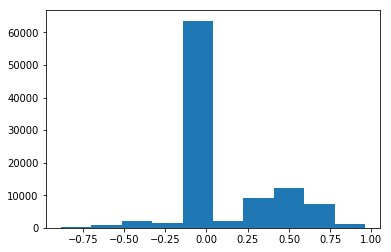

In [171]:
plt.hist(df_train.title_sent_compound)

(array([  555.,   265.,   215.,   209.,   171.,   211.,   398.,   710.,
         1824., 95442.]),
 array([-9.9850e-01, -7.9867e-01, -5.9884e-01, -3.9901e-01, -1.9918e-01,
         6.5000e-04,  2.0048e-01,  4.0031e-01,  6.0014e-01,  7.9997e-01,
         9.9980e-01]),
 <a list of 10 Patch objects>)

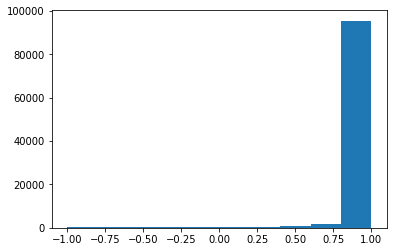

In [216]:
plt.hist(df_train.essay_sent_compound)

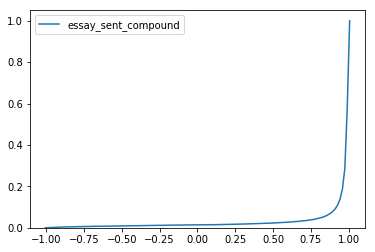

In [220]:
sns.kdeplot(df_train.essay_sent_compound, cumulative=True)

In [221]:
(df_train.essay_sent_compound > 0.8).mean()

0.9544

In [222]:
(df_train.essay_sent_compound > 0.9).mean()

0.91709

(array([3.3500e+02, 2.1741e+04, 4.4818e+04, 2.4139e+04, 8.2890e+03,
        5.2300e+02, 1.1000e+02, 2.9000e+01, 9.0000e+00, 7.0000e+00]),
 array([1.000e+00, 1.037e+02, 2.064e+02, 3.091e+02, 4.118e+02, 5.145e+02,
        6.172e+02, 7.199e+02, 8.226e+02, 9.253e+02, 1.028e+03]),
 <a list of 10 Patch objects>)

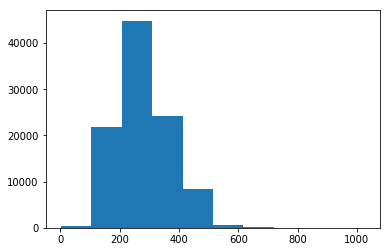

In [217]:
plt.hist(df_train.essay_word_count)

In [ ]:
## Examine most positive/negative/neutral titles and essays

In [211]:
# Most positive titles: 
rows = df_train.sort_values('title_sent_compound')[-10:]
for idx in rows.index:
    row = rows.loc[idx]
    print(row.title_sent_compound.astype(str) + " (funded = " + row[outcome].astype(str) + ') \n' + row.title + '\n')

0.9299 (funded = 1) 
Active Engagement = Great Success!

0.93 (funded = 1) 
Inspiring and Awesome Books for Inspiring Awesome Students

0.9311 (funded = 0) 
We Need a Hero! Help Us Celebrate Real Heroes!

0.9312 (funded = 1) 
Transitional Kindergarten, I Love It, I Love It, I Love It!

0.9312 (funded = 1) 
We Love, Love, Love Science!

0.9337 (funded = 1) 
A Pleasant Place to Celebrate Our Love of Learning <3

0.9349 (funded = 0) 
Celebrating Success: Awards For Amazing Students

0.936 (funded = 1) 
Healthy Hope + Fact-Finding Friends = A Wealth of Wisdom

0.9411 (funded = 1) 
We Love, Love, Love Art and Need an Easel!!!

0.9621 (funded = 1) 
We LOVE Reading So PLEASE Help Us Get This GREAT Novel!



In [210]:
# Most negative titles: 
rows = df_train.sort_values('title_sent_compound')[:10]
for idx in rows.index:
    row = rows.loc[idx]
    print(row.title_sent_compound.astype(str) + " (funded = " + row[outcome].astype(str) + ') \n' + row.title + '\n')

-0.8834 (funded = 1) 
Stop Hatred And Bullying With Readers' Library

-0.8805 (funded = 0) 
Budget Cuts Hurt Worse Than Paper Cuts!

-0.8777 (funded = 1) 
Oh No! Our iPod  Is Showing the "Dreaded Apple of Death.

-0.8689 (funded = 1) 
Scare Kids to Read: Disgusting, Fearful Literacy Motivators

-0.8658 (funded = 1) 
Slavery & The Civil War: Personal Accounts 

-0.8658 (funded = 0) 
Stop Violence, Remember 39, Help Us Fight Against Crime

-0.8528 (funded = 1) 
No Frustration...Helps with NO Bullying!

-0.8528 (funded = 1) 
STOP IT! Stop Bullying Now Public Service Announcements

-0.8519 (funded = 1) 
Remember, It's A Sin To Kill A Mockingbird

-0.8513 (funded = 0) 
Dead Obsolete Copier of No Use to Students!!



In [212]:
# Totally neutral titles
rows = df_train.query('title_sent_compound == 0')[:10]
for idx in rows.index:
    row = rows.loc[idx]
    print(row.title_sent_compound.astype(str) + " (funded = " + row[outcome].astype(str) + ') \n' + row.title + '\n')

0.0 (funded = 1) 
Bringing Reading, Math, and Science to Life

0.0 (funded = 0) 
High Flying Fractions for Real Learning

0.0 (funded = 1) 
Introductory  Microscopes

0.0 (funded = 1) 
Keyboarding Equals Common Core!

0.0 (funded = 1) 
Beyond Brains and Books 

0.0 (funded = 1) 
Leaping Into Literacy

0.0 (funded = 1) 
From Videomaking and Multi-Media Editing to Puppetry

0.0 (funded = 1) 
Do You Hear What I Hear?

0.0 (funded = 1) 
I Can Read...Just Right Books!

0.0 (funded = 1) 
AirPlay



In [214]:
# Most positive essays: 
rows = df_train.sort_values('essay_sent_compound')[-5:]
for idx in rows.index:
    row = rows.loc[idx]
    print(row.essay_sent_compound.astype(str) + " (funded = " + row[outcome].astype(str) + ') \n' + row.essay + '\n')

0.9996 (funded = 1) 
\nBy helping us to expand our classroom library, you will add to the excitement that all of my students have towards reading while providing them the opportunity to strengthen their reading skills.  You will help those that have special challenges such as learning disabilities get the extra practice they need and feel the success they crave.  You will also help my average and above-average readers extend themselves and their comprehension by reading more non-fiction books.  Thank you for your consideration and support. Many of the titles we are seeking are written at a level that will not frustrate them, but can still stimulate their mature interests.  Success breeds success with all students, but it is especially important for students who have extra challenges decoding the words on a page.  Because many of these titles are shorter stories, it is important to have a large variety of them.  This allows the children enjoy the thrill of success on the computer and th

In [215]:
# Most negative essays: 
rows = df_train.sort_values('essay_sent_compound')[:5]
for idx in rows.index:
    row = rows.loc[idx]
    print(row.essay_sent_compound.astype(str) + " (funded = " + row[outcome].astype(str) + ') \n' + row.essay + '\n')

-0.9985 (funded = 1) 
\nConsidering the neighborhood my students come from, it is no surprise that they would see intimidation as a flight-or-fight response. However, I want them to know that bullying is not okay. With these resources, my class would learn more about the negative aspects of bullying and what they can do if they are bullied or witness bullying. I am hopeful that if we teach children about empathy at an early age, they will be less likely to become a bullying statistic later in life.  help us further our investigation regarding bullying, as we would be able to find age-appropriate clips that we would be able to discuss and later act out. Students would also be able to familiarize themselves with a computer as we search for anti-bullying sites. 

-0.9981 (funded = 1) 
\nMy students need Bullying in School and books on bullying so they can better understand bullying and a camera to take pictures to make a book of their own on bullying. My students are often the victims of 

## What are the correlations of the scores with the outcome? 

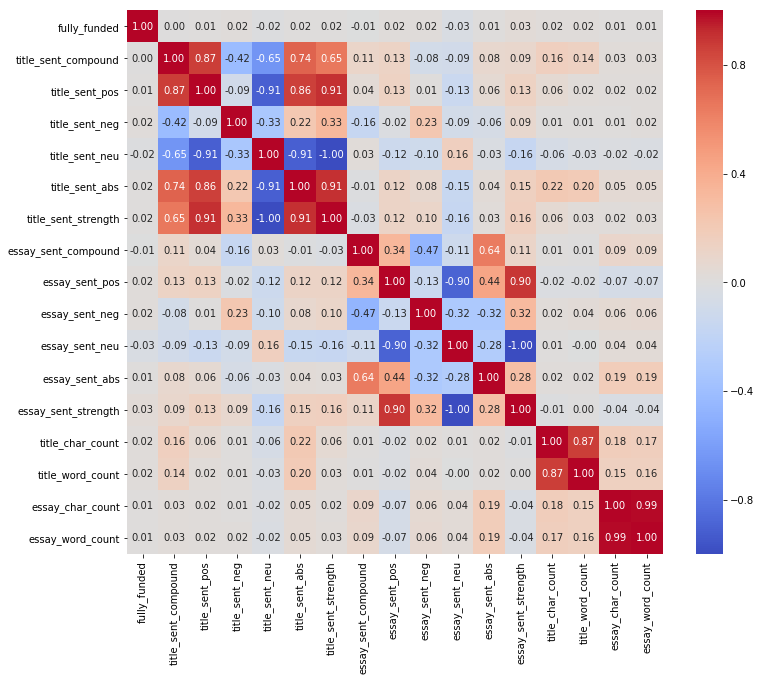

In [183]:
cols = [outcome] + features 
corr = df_train[cols].corr()
plt.figure(figsize=[12,10])
g = sns.heatmap(corr, annot=True, fmt = ".2f", cmap = "coolwarm", center=0)

## Okay, can we build a model with these features? 

In [124]:
def pipeline_cv_score(model_pipeline, X, y, n_jobs=-1):
    """Display cross-validation score of a pipeline given data X and y"""
    cv_score = cross_val_score(model_pipeline, X, y, cv=tscv, n_jobs=n_jobs)
    print(f'Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_feature_importances(df, n=20, threshold=None, return_df=False):
    """
    Slightly adapted from https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough
    Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances.
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
        n (int): Number of most important features to plot. Default is 15.
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1)
                        and a cumulative importance column
    Note:
        * Normalization in this case means sums to 1.
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    """
    plt.style.use('fivethirtyeight')

    # Sort features with most important at the head
    df = df.sort_values('importance', ascending=False).reset_index(drop=True)

    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    plt.rcParams['font.size'] = 12

    # Bar plot of n most important features
    plt.figure(figsize=(8, 0.5*n))
    df.loc[:n, :].plot.barh(y='importance_normalized',
                            x='feature', color='darkgreen',
                            edgecolor='k', figsize=(12, 8),
                            legend=False, linewidth=2)

    plt.xlabel('Normalized Importance', size=18);
    plt.ylabel('');
    plt.title(f'{n} Most Important Features', size=18)
    plt.gca().invert_yaxis()

    if threshold:
        # Cumulative importance plot
        plt.figure(figsize=(8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size=16);
        plt.ylabel('Cumulative Importance', size=16);
        plt.title('Cumulative Feature Importance', size=18);

        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))

        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin=0, ymax=1.05, linestyles='--', colors='red')
        plt.show();

        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1,
                                                                                  100 * threshold))

    if return_df:
        return df

In [196]:
rf = RandomForestClassifier(max_depth=3, n_estimators=20, random_state=42)

In [189]:
X_train = df_train[features]
y_train = df_train[outcome]

Wall time: 7.43 s


<module 'matplotlib.pyplot' from 'c:\\users\\zrankin\\appdata\\local\\continuum\\miniconda3\\envs\\kaggle\\lib\\site-packages\\matplotlib\\pyplot.py'>

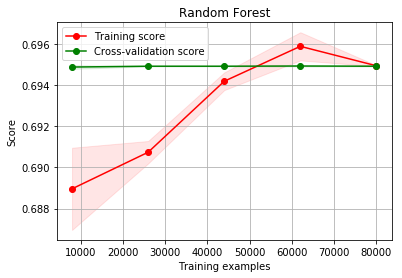

In [197]:
%%time
plot_learning_curve(rf, 'Random Forest', X_train, y_train, cv=5)

# Yep, the model is garbage. 
But I'll run the shap values anyway 

In [198]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

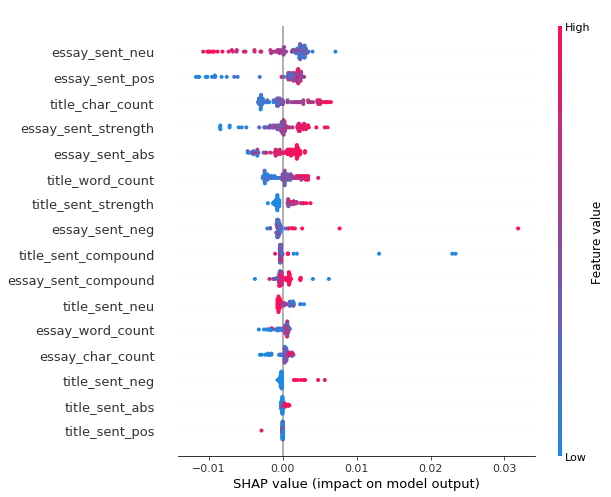

In [199]:
df_subset = X_train.sample(100, random_state=42)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(df_subset)
shap.summary_plot(shap_values[1], df_subset, max_display=30)